In [86]:
import numpy as np

from pathlib import Path
import re
from random import randint

import tkinter as tk
from tkinter import filedialog

import json
import struct

import matplotlib.pyplot as plt

In [29]:
root = tk.Tk()
root.withdraw()

In [30]:
def get_map_dimensions(file_path:Path):
  """Gets the measured map's dimensions (in pixels) assuming that the filename contains this information

  Args:
      file_path (Path): pathlib.Path object of the considered map's data
  """
  map_dimensions = re.findall(
      '[0-9]{3}x[0-9]{3}',
      file_path.name
  )[0].split('x')

  return([int(x) for x in map_dimensions])

def get_metadata(file_path:Path):
  """Load metadata from the metadata file corresponding to the selected data file

  Args:
      file_path (Path): pathlib.Path object of the considered map's data
  """
  metadata_path = file_path.with_suffix('.libsmetadata')
  if metadata_path.is_file():
    with open(
      file_path.with_suffix('.libsmetadata'),'r'
    ) as file:

      return(json.load(file))
  else:
    raise ImportError('Metadata file is missing')

In [31]:
get_metadata(file_path)

{'data': [{'Index of measurement': '0'},
  {'Index of measurement': '1'},
  {'Index of measurement': '2'},
  {'Index of measurement': '3'},
  {'Index of measurement': '4'},
  {'Index of measurement': '5'},
  {'Index of measurement': '6'},
  {'Index of measurement': '7'},
  {'Index of measurement': '8'},
  {'Index of measurement': '9'},
  {'Index of measurement': '10'},
  {'Index of measurement': '11'},
  {'Index of measurement': '12'},
  {'Index of measurement': '13'},
  {'Index of measurement': '14'},
  {'Index of measurement': '15'},
  {'Index of measurement': '16'},
  {'Index of measurement': '17'},
  {'Index of measurement': '18'},
  {'Index of measurement': '19'},
  {'Index of measurement': '20'},
  {'Index of measurement': '21'},
  {'Index of measurement': '22'},
  {'Index of measurement': '23'},
  {'Index of measurement': '24'},
  {'Index of measurement': '25'},
  {'Index of measurement': '26'},
  {'Index of measurement': '27'},
  {'Index of measurement': '28'},
  {'Index of mea

In [159]:
#%%writefile ../src/MapData.py

class MapData:
  """Class for handling hyperspectral images stored in the .libsdata file format
  """
  def __init__(self):
    self.file_path = Path(
      filedialog.askopenfilename(filetypes=[('LIBS data','*.libsdata')])
    )
    self.BYTE_SIZE = 4


  def get_map_dimensions(self):
    """Gets the measured map's dimensions (in pixels) assuming that the filename contains this information
    """
    map_dimensions = re.findall(
        '[0-9]{3}x[0-9]{3}',
        self.file_path.name
    )[0].split('x')

    self.map_dimensions = [int(x) for x in map_dimensions]


  def get_metadata(self):
    """Load metadata from the metadata file corresponding to the selected data file
    """
    metadata_path = self.file_path.with_suffix('.libsmetadata')
    if metadata_path.is_file():
      with open(
        self.file_path.with_suffix('.libsmetadata'),'r'
      ) as file:

        self.metadata = json.load(file)
    else:
      raise ImportError('Metadata file is missing')
    

  def load_wavelenths(self):
    """Load the wavelength vector from the binary data file
    """
    with open(self.file_path,'rb') as source:        
        self.wvl = []
        
        for _ in range(self.metadata.get('wavelengths')):
          self.wvl.extend(
            struct.unpack(
                'f',source.read(self.BYTE_SIZE)
            )
          )

        self.wvl = np.array(self.wvl)


  def load_batch_of_spectra(self, batch_size:int, start_ndx:int):
    """Load a batch of consecutive spectra from the binary data file

    Args:
        batch_size (int): number of spectra to load
        start_ndx (int): index of the first spectrum in the batch (in the whole data file)
    """
    with open(self.file_path,'rb') as source:
      source.seek(
        (1 + start_ndx) * self.metadata.get('wavelengths') * self.BYTE_SIZE,
        0
      )

      data = []
      for _ in range(self.metadata.get('wavelengths') * batch_size):

        data.extend(
          struct.unpack(
            'f',source.read(self.BYTE_SIZE)
          )
        )

      self.data = np.reshape(
          data,
          (-1,self.metadata.get('wavelengths'))
      )


  def load_random_spectrum_from_batch(self, batch_size:int):
    """Loads a single spectrum from every batch defined by the batch_size parameter

    Args:
        batch_size (int): Number of spectra from which 1 is randomly sampled
    """
    batch_count = self.metadata.get('spectra') // batch_size
    
    data = []
    with open(self.file_path,'rb') as source:      
      source.seek(
        self.metadata.get('wavelengths') * self.BYTE_SIZE,
        0
      )

      for _ in range(batch_count):
        ndx = randint(0,batch_size)
        source.seek(
          self.metadata.get('wavelengths') * self.BYTE_SIZE * ndx,
          1
        )
        for _ in range(self.metadata.get('wavelengths')):
          data.extend(
            struct.unpack(
              'f',source.read(self.BYTE_SIZE)
            )
          )
        if ndx != batch_size:
          source.seek(
            self.metadata.get('wavelengths') * self.BYTE_SIZE * (batch_size - ndx),
            1
          )
          
    self.data = np.reshape(
        data,
        (-1,self.metadata.get('wavelengths'))
    )

  
  def load_random_spectrum(self):
    """Load a random spectrum from the whole data file
    """
    data = []
    with open(self.file_path,'rb') as source:
      chosen_ndx = randint(1,self.metadata.get('spectra'))
      source.seek(
        self.metadata.get('wavelengths') * self.BYTE_SIZE * chosen_ndx,
        0
      )
      for _ in range(self.metadata.get('wavelengths')):
        data.extend(
          struct.unpack(
            'f',source.read(self.BYTE_SIZE)
          )
        )
      return(np.array(data))


  def plot_random_spectrum(self):
    """plot a random spectrum from the file
    """
    fig,ax = plt.subplots()
    if not self.load_wavelenths:
      self.load_wavelenths()

    ax.plot(
      self.wvl,
      self.load_random_spectrum()
    )
    fig.show()

In [160]:
map_data = MapData()
map_data.get_metadata()
map_data.get_map_dimensions()
map_data.load_wavelenths()

In [164]:
map_data.load_random_spectrum_from_batch(10000)

In [165]:
map_data.data.shape

(31, 4094)

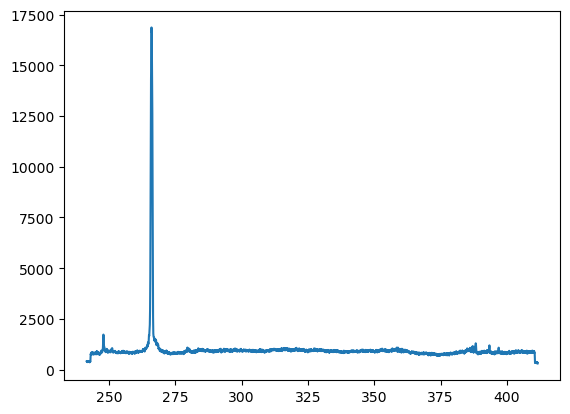

In [167]:
plt.plot(
    map_data.wvl,
    map_data.data.mean(axis=0)
)